<a href="https://colab.research.google.com/github/rashmi05pathak/CS6910_Assignment_2/blob/main/EE20S051_Assignment2A_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [69]:
!pip install wandb

In [70]:
import numpy as np
import pandas as pd
import os
import keras
import tensorflow as tf
from tensorflow.keras import layers,models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten, Activation , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from wandb.keras import WandbCallback
import matplotlib.pyplot as plt
import cv2
import wandb
import matplotlib.image as mpimg

In [3]:
%%capture
!curl -SL https://storage.googleapis.com/wandb_datasets/nature_12K.zip > nature_12K.zip
!unzip nature_12K.zip

train_dir='inaturalist_12K/train/'
test_dir='inaturalist_12K/val/'
classes=['Amphibia','Animalia','Arachnida','Aves','Fungi','Insecta','Mammalia','Mollusca','Plantae','Reptilia']

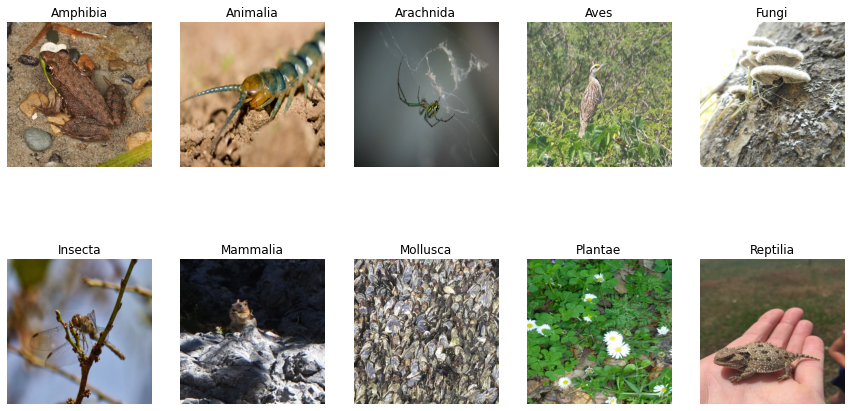

In [4]:
#visualizing images: one from each classes
fig = plt.figure(figsize=(15,8))
rows,columns= 2,5
i=1
for clas in classes: #10 unique classes
  dir=os.path.join(train_dir,clas)
  for img in os.listdir(dir):
    img_path=(os.path.join(dir,img))
    imgs=mpimg.imread(img_path)
    #image size
    #print(imgs.shape)
    new_img=cv2.resize(imgs,(512,512))
    fig.add_subplot(rows,columns,i)
    plt.imshow(new_img)
    plt.axis('off')
    plt.title(clas)
    i+=1   
    break
 

In [5]:
def customized_dataGenerator(h,w):
    img_height,img_width= h ,w
    #data generators for train and validation set
    
    augment= ImageDataGenerator(
             rotation_range=30,
             width_shift_range=0.2,
             height_shift_range=0.2,
             shear_range=0.2,
             zoom_range=0.2,
             horizontal_flip=True,
             rescale=1.0 / 255,
             validation_split=0.1
             )

    datagen = ImageDataGenerator(
              rescale=1.0 / 255,
              validation_split=0.1
              )

    train_set = datagen.flow_from_directory(
                train_dir,
                target_size=(img_height, img_width),
                batch_size=32,
                color_mode='rgb',
                class_mode='sparse',
                shuffle=True,
                subset='training',
                seed=95,
                )
    aug_set= augment.flow_from_directory(
            train_dir,
            target_size=(img_height, img_width),
            batch_size=32,
            color_mode='rgb',
            class_mode='sparse',
            shuffle=True,
            subset='training',
            seed=95,
           )

    val_set= datagen.flow_from_directory(
              train_dir,
              target_size=(img_height, img_width),
              color_mode='rgb',
              class_mode='sparse',
              shuffle=True,
              subset='validation',
              seed=95,
              )
    return train_set, aug_set, val_set


In [6]:
def customized_model(filters,batchnorm,act,fc_size,droprate,h,w):
     model=models.Sequential()
     model.add(Conv2D(filters[0], (3, 3),input_shape=(h,w,3),activation=act))    
     if batchnorm =='yes':
        model.add(BatchNormalization())
     model.add(MaxPooling2D((2, 2)))

     model.add(Conv2D(filters[1], (3, 3),activation=act))
     model.add(MaxPooling2D((2, 2)))

     model.add(Conv2D(filters[2], (3, 3),activation=act))
     model.add(MaxPooling2D((2, 2)))
    
     model.add(Conv2D(filters[3], (3, 3),activation=act))
     model.add(MaxPooling2D((2, 2)))
     
     model.add(Conv2D(filters[4], (3, 3),activation=act))
     if batchnorm =='yes':
        model.add(BatchNormalization())
     model.add(MaxPooling2D((2, 2)))
    
     model.add(Flatten())
     model.add(Dense(fc_size,activation=act)) 
     if batchnorm =='yes':
        model.add(BatchNormalization())
     model.add(Dropout(droprate))
     model.add(Dense(10,activation='softmax')) #Because of classification problem using softmax function 
     model.compile(
          optimizer=tf.keras.optimizers.Adam(),
          loss=[tf.keras.losses.SparseCategoricalCrossentropy()],
          metrics=['accuracy'],
          )
     return model

In [7]:
sweep_config1 = {
  'name': 'sweep1',  
  'method': 'grid',
  'parameters': {
        
        'filters': {
            'values': ['inc_dec','dec_inc','all_64','all_32','inc','dec']
        },
        'fc_size':{
            'values':[128]
        },
        'batchnorm':{
            'values':['yes']
        },
        'augmentation':{
            'values':['yes','No']   
        },
        'droprate':{
            'values':[0.2,0.3,0.4,0.5]
        }
           
    }

}

sweep_config2 = {
  'name': 'sweep2',  
  'method': 'random',
  'parameters': {
        
        'filters': {
            'values': ['inc_dec','dec_inc','all_64','all_32','all_128','inc','dec']
        },
        'fc_size':{
            'values':[128]
        },
        'batchnorm':{
            'values':['yes']
        },
        'augmentation':{
            'values':['yes','No']   
        },
        'droprate':{
            'values':[0.4,0.5]
        }
           
    }

}

config_defaults={
    'filters':'inc',
    'fc_size':256,
    'batchnorm':'yes',
    'augmentation':'no',
    'droprate':0.3
}

In [8]:
def Train_CNN():

  #wandb.init(config=config_defaults)
  #configs=wandb.config

  configs=config_defaults

  batchnorm=configs['batchnorm']
  droprate=configs['droprate']
  augmentation=configs['augmentation']
  filter_=configs['filters']
  fc_size=configs['fc_size']

  #wandb.run.name='filters_'+filter_+'_fc_size_'+str(fc_size)+'_droprate_'+str(droprate)+ str('_bn_' if batchnorm=='yes' else '') +str('augment' if augmentation=='yes' else '')

  if filter_ == 'all_32':
    filters=[32,32,32,32,32]
  elif filter_=='all_64' :
    filters=[64,64,64,64,64]
  elif filter_=='all_128' :
    filters=[128,128,128,128,128]
  elif filter_=='inc' :
    filters=[16,32,64,128,256]
  elif filter_ == 'dec' :
    filters=[128,64,32,16,8]
  elif filter_ =='inc_dec':
    filters=[32,64,128,64,32]
  elif filter_ =='dec_inc' :
    filters=[128,64,32,64,128]


  img_height,img_width=128 ,128
  act = 'relu'
  #preparing model architecure with the given Q1(A) specifications
  model = customized_model(filters,batchnorm,act,fc_size,droprate,img_height,img_width)
  # Getting the training and validation data using ImageDataGenerator function of keras 
  train_set,aug_set,val_set = customized_dataGenerator(img_height,img_width) 
 
  if augmentation =='no' :
    #hist=model.fit(train_set,epochs=10,validation_data=val_set,callbacks=[WandbCallback()])
     hist=model.fit(train_set,epochs=10,validation_data=val_set)

  else:
    #hist=model.fit(aug_set,epochs=10,validation_data=val_set,callbacks=[WandbCallback()])
    hist=model.fit(aug_set,epochs=10,validation_data=val_set)
  
  val_acc=max(hist.history['val_accuracy'])
  params={'batch_norm':batchnorm,'augmentation':augmentation,'dropout':droprate,'filter_architecture':filter_,'val_acc':val_acc}
  #wandb.log(params)

In [ ]:
#Using Wandb to do hyperparameter tuning
#sweep_id=wandb.sweep(sweep_config1,entity='rashmi05pathak',project='assignment_2')
#wandb.agent(sweep_id, Train_CNN)         

<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Create sweep with ID: r9tn0fki
Sweep URL: https://wandb.ai/rashmi05pathak/assignment_2/sweeps/r9tn0fki


wandb: Agent Starting Run: ydk2gpd4 with config:
wandb: 	augmentation: yes
wandb: 	batchnorm: yes
wandb: 	droprate: 0.2
wandb: 	fc_size: 128
wandb: 	filters: inc_dec


Found 9000 images belonging to 10 classes.
Found 9000 images belonging to 10 classes.
Found 999 images belonging to 10 classes.
Epoch 1/10
282/282 [==============================] - 138s 449ms/step - loss: 2.4385 - accuracy: 0.2081 - val_loss: 2.7900 - val_accuracy: 0.1331
Epoch 2/10
282/282 [==============================] - 124s 439ms/step - loss: 2.1778 - accuracy: 0.2613 - val_loss: 2.1643 - val_accuracy: 0.2402
Epoch 3/10
282/282 [==============================] - 121s 428ms/step - loss: 2.0733 - accuracy: 0.2843 - val_loss: 2.1799 - val_accuracy: 0.2703
Epoch 4/10
282/282 [==============================] - 121s 428ms/step - loss: 2.0022 - accuracy: 0.3031 - val_loss: 2.0599 - val_accuracy: 0.3093
Epoch 5/10
282/282 [==============================] - 121s 429ms/step - loss: 1.9321 - accuracy: 0.3267 - val_loss: 2.4470 - val_accuracy: 0.2382
Epoch 6/10
282/282 [==============================] - 120s 425ms/step - loss: 1.8453 - accuracy: 0.3477 - val_loss: 2.3998 - val_accuracy: 0.2

wandb: Agent Starting Run: z21yodhl with config:
wandb: 	augmentation: yes
wandb: 	batchnorm: yes
wandb: 	droprate: 0.2
wandb: 	fc_size: 128
wandb: 	filters: dec_inc


Found 9000 images belonging to 10 classes.
Found 9000 images belonging to 10 classes.
Found 999 images belonging to 10 classes.
Epoch 1/10
282/282 [==============================] - 143s 503ms/step - loss: 2.3740 - accuracy: 0.2108 - val_loss: 2.9317 - val_accuracy: 0.1001
Epoch 2/10
282/282 [==============================] - 121s 426ms/step - loss: 2.1722 - accuracy: 0.2628 - val_loss: 2.1545 - val_accuracy: 0.2262
Epoch 3/10
282/282 [==============================] - 122s 433ms/step - loss: 2.0620 - accuracy: 0.2810 - val_loss: 2.2025 - val_accuracy: 0.2613
Epoch 4/10
282/282 [==============================] - 122s 431ms/step - loss: 1.9678 - accuracy: 0.3121 - val_loss: 2.5071 - val_accuracy: 0.2573
Epoch 5/10
282/282 [==============================] - 120s 425ms/step - loss: 1.9013 - accuracy: 0.3329 - val_loss: 2.1781 - val_accuracy: 0.2673
Epoch 6/10
282/282 [==============================] - 121s 429ms/step - loss: 1.8202 - accuracy: 0.3578 - val_loss: 2.3897 - val_accuracy: 0.2

wandb: Agent Starting Run: ap1vufkp with config:
wandb: 	augmentation: yes
wandb: 	batchnorm: yes
wandb: 	droprate: 0.2
wandb: 	fc_size: 128
wandb: 	filters: all_64


Found 9000 images belonging to 10 classes.
Found 9000 images belonging to 10 classes.
Found 999 images belonging to 10 classes.
Epoch 1/10
282/282 [==============================] - 123s 431ms/step - loss: 2.4111 - accuracy: 0.2050 - val_loss: 3.5623 - val_accuracy: 0.1011
Epoch 2/10
282/282 [==============================] - 122s 433ms/step - loss: 2.1864 - accuracy: 0.2553 - val_loss: 2.1579 - val_accuracy: 0.2442
Epoch 3/10
282/282 [==============================] - 121s 431ms/step - loss: 2.0737 - accuracy: 0.2861 - val_loss: 2.2127 - val_accuracy: 0.2703
Epoch 4/10
282/282 [==============================] - 121s 430ms/step - loss: 1.9758 - accuracy: 0.3123 - val_loss: 2.1887 - val_accuracy: 0.2923
Epoch 5/10
282/282 [==============================] - 120s 424ms/step - loss: 1.8848 - accuracy: 0.3416 - val_loss: 2.1249 - val_accuracy: 0.2623
Epoch 6/10
282/282 [==============================] - 119s 422ms/step - loss: 1.8150 - accuracy: 0.3577 - val_loss: 1.9590 - val_accuracy: 0.3

wandb: Agent Starting Run: ydk2gpd4 with config:
wandb: 	augmentation: yes
wandb: 	batchnorm: yes
wandb: 	droprate: 0.2
wandb: 	fc_size: 128
wandb: 	filters: inc_dec


Found 9000 images belonging to 10 classes.
Found 9000 images belonging to 10 classes.
Found 999 images belonging to 10 classes.
Epoch 1/10
282/282 [==============================] - 128s 448ms/step - loss: 2.4110 - accuracy: 0.2037 - val_loss: 2.6503 - val_accuracy: 0.1602
Epoch 2/10
282/282 [==============================] - 124s 438ms/step - loss: 2.1912 - accuracy: 0.2506 - val_loss: 2.7311 - val_accuracy: 0.1912
Epoch 3/10
282/282 [==============================] - 123s 436ms/step - loss: 2.0859 - accuracy: 0.2860 - val_loss: 2.1809 - val_accuracy: 0.2482
Epoch 4/10
282/282 [==============================] - 124s 438ms/step - loss: 1.9956 - accuracy: 0.3061 - val_loss: 2.2023 - val_accuracy: 0.2723
Epoch 5/10
282/282 [==============================] - 127s 451ms/step - loss: 1.9272 - accuracy: 0.3253 - val_loss: 1.9793 - val_accuracy: 0.3143
Epoch 6/10
282/282 [==============================] - 124s 438ms/step - loss: 1.8652 - accuracy: 0.3458 - val_loss: 2.0989 - val_accuracy: 0.2

wandb: Agent Starting Run: z21yodhl with config:
wandb: 	augmentation: yes
wandb: 	batchnorm: yes
wandb: 	droprate: 0.2
wandb: 	fc_size: 128
wandb: 	filters: dec_inc


Found 9000 images belonging to 10 classes.
Found 9000 images belonging to 10 classes.
Found 999 images belonging to 10 classes.
Epoch 1/10
282/282 [==============================] - 128s 448ms/step - loss: 2.4041 - accuracy: 0.2033 - val_loss: 2.6305 - val_accuracy: 0.1572
Epoch 2/10
282/282 [==============================] - 123s 435ms/step - loss: 2.1827 - accuracy: 0.2583 - val_loss: 2.2790 - val_accuracy: 0.2412
Epoch 3/10
282/282 [==============================] - 123s 437ms/step - loss: 2.0872 - accuracy: 0.2839 - val_loss: 2.7305 - val_accuracy: 0.2362
Epoch 4/10
282/282 [==============================] - 123s 437ms/step - loss: 1.9650 - accuracy: 0.3172 - val_loss: 2.0518 - val_accuracy: 0.2793
Epoch 5/10
282/282 [==============================] - 123s 436ms/step - loss: 1.9267 - accuracy: 0.3286 - val_loss: 2.4943 - val_accuracy: 0.2142
Epoch 6/10
282/282 [==============================] - 123s 435ms/step - loss: 1.8625 - accuracy: 0.3449 - val_loss: 2.1315 - val_accuracy: 0.2

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ap1vufkp with config:
wandb: 	augmentation: yes
wandb: 	batchnorm: yes
wandb: 	droprate: 0.2
wandb: 	fc_size: 128
wandb: 	filters: all_64


Found 9000 images belonging to 10 classes.
Found 9000 images belonging to 10 classes.
Found 999 images belonging to 10 classes.
Epoch 1/10
282/282 [==============================] - 127s 446ms/step - loss: 2.4286 - accuracy: 0.2070 - val_loss: 2.7470 - val_accuracy: 0.1461
Epoch 2/10
282/282 [==============================] - 124s 438ms/step - loss: 2.1744 - accuracy: 0.2623 - val_loss: 2.1347 - val_accuracy: 0.2703
Epoch 3/10
282/282 [==============================] - 123s 435ms/step - loss: 2.0860 - accuracy: 0.2790 - val_loss: 2.2690 - val_accuracy: 0.2332
Epoch 4/10
282/282 [==============================] - 122s 432ms/step - loss: 2.0055 - accuracy: 0.3014 - val_loss: 2.4009 - val_accuracy: 0.2182
Epoch 5/10
282/282 [==============================] - 121s 431ms/step - loss: 1.9186 - accuracy: 0.3303 - val_loss: 1.9219 - val_accuracy: 0.3313
Epoch 6/10
282/282 [==============================] - 121s 431ms/step - loss: 1.8504 - accuracy: 0.3592 - val_loss: 1.9553 - val_accuracy: 0.3

wandb: Agent Starting Run: ydk2gpd4 with config:
wandb: 	augmentation: yes
wandb: 	batchnorm: yes
wandb: 	droprate: 0.2
wandb: 	fc_size: 128
wandb: 	filters: inc_dec


Found 9000 images belonging to 10 classes.
Found 9000 images belonging to 10 classes.
Found 999 images belonging to 10 classes.
Epoch 1/10
282/282 [==============================] - 122s 430ms/step - loss: 2.4162 - accuracy: 0.2043 - val_loss: 2.7949 - val_accuracy: 0.1381
Epoch 2/10
282/282 [==============================] - 120s 426ms/step - loss: 2.1933 - accuracy: 0.2520 - val_loss: 2.5432 - val_accuracy: 0.1812
Epoch 3/10
282/282 [==============================] - 121s 428ms/step - loss: 2.0877 - accuracy: 0.2782 - val_loss: 2.1239 - val_accuracy: 0.2623
Epoch 4/10
282/282 [==============================] - 121s 430ms/step - loss: 1.9807 - accuracy: 0.3083 - val_loss: 2.3086 - val_accuracy: 0.2072
Epoch 5/10
282/282 [==============================] - 121s 429ms/step - loss: 1.9176 - accuracy: 0.3294 - val_loss: 2.0148 - val_accuracy: 0.2663
Epoch 6/10
282/282 [==============================] - 121s 429ms/step - loss: 1.8604 - accuracy: 0.3449 - val_loss: 2.1083 - val_accuracy: 0.2

wandb: Agent Starting Run: z21yodhl with config:
wandb: 	augmentation: yes
wandb: 	batchnorm: yes
wandb: 	droprate: 0.2
wandb: 	fc_size: 128
wandb: 	filters: dec_inc


Found 9000 images belonging to 10 classes.
Found 9000 images belonging to 10 classes.
Found 999 images belonging to 10 classes.
Epoch 1/10
282/282 [==============================] - 132s 465ms/step - loss: 2.3820 - accuracy: 0.2203 - val_loss: 2.9215 - val_accuracy: 0.1081
Epoch 2/10
282/282 [==============================] - 122s 433ms/step - loss: 2.1618 - accuracy: 0.2638 - val_loss: 2.2760 - val_accuracy: 0.2342
Epoch 3/10
282/282 [==============================] - 122s 432ms/step - loss: 2.0493 - accuracy: 0.2947 - val_loss: 2.4619 - val_accuracy: 0.2533
Epoch 4/10
282/282 [==============================] - 123s 435ms/step - loss: 1.9838 - accuracy: 0.3144 - val_loss: 2.1771 - val_accuracy: 0.2963
Epoch 5/10
282/282 [==============================] - 123s 435ms/step - loss: 1.8883 - accuracy: 0.3373 - val_loss: 1.9715 - val_accuracy: 0.3273
Epoch 6/10
282/282 [==============================] - 131s 465ms/step - loss: 1.8238 - accuracy: 0.3616 - val_loss: 2.1784 - val_accuracy: 0.2

wandb: Agent Starting Run: ap1vufkp with config:
wandb: 	augmentation: yes
wandb: 	batchnorm: yes
wandb: 	droprate: 0.2
wandb: 	fc_size: 128
wandb: 	filters: all_64


Found 9000 images belonging to 10 classes.
Found 9000 images belonging to 10 classes.
Found 999 images belonging to 10 classes.
Epoch 1/10
282/282 [==============================] - 134s 472ms/step - loss: 2.3913 - accuracy: 0.2132 - val_loss: 2.7611 - val_accuracy: 0.1021
Epoch 2/10
282/282 [==============================] - 125s 442ms/step - loss: 2.1646 - accuracy: 0.2556 - val_loss: 3.0419 - val_accuracy: 0.1962
Epoch 3/10
282/282 [==============================] - 123s 437ms/step - loss: 2.0702 - accuracy: 0.2847 - val_loss: 2.6316 - val_accuracy: 0.1872
Epoch 4/10
282/282 [==============================] - 123s 435ms/step - loss: 1.9642 - accuracy: 0.3093 - val_loss: 2.3772 - val_accuracy: 0.2803
Epoch 5/10
282/282 [==============================] - 123s 438ms/step - loss: 1.9023 - accuracy: 0.3354 - val_loss: 2.0691 - val_accuracy: 0.3113
Epoch 6/10
282/282 [==============================] - 124s 439ms/step - loss: 1.8513 - accuracy: 0.3506 - val_loss: 1.9922 - val_accuracy: 0.3

wandb: Agent Starting Run: ydk2gpd4 with config:
wandb: 	augmentation: yes
wandb: 	batchnorm: yes
wandb: 	droprate: 0.2
wandb: 	fc_size: 128
wandb: 	filters: inc_dec


Found 9000 images belonging to 10 classes.
Found 9000 images belonging to 10 classes.
Found 999 images belonging to 10 classes.
Epoch 1/10
282/282 [==============================] - 127s 448ms/step - loss: 2.4104 - accuracy: 0.2066 - val_loss: 2.7205 - val_accuracy: 0.1702
Epoch 2/10
282/282 [==============================] - 125s 442ms/step - loss: 2.1562 - accuracy: 0.2639 - val_loss: 2.2592 - val_accuracy: 0.1942
Epoch 3/10
282/282 [==============================] - 125s 442ms/step - loss: 2.0931 - accuracy: 0.2777 - val_loss: 2.1186 - val_accuracy: 0.2853
Epoch 4/10
282/282 [==============================] - 125s 442ms/step - loss: 1.9884 - accuracy: 0.3049 - val_loss: 2.8296 - val_accuracy: 0.2022
Epoch 5/10
282/282 [==============================] - 122s 433ms/step - loss: 1.8999 - accuracy: 0.3433 - val_loss: 3.1090 - val_accuracy: 0.1612
Epoch 6/10
282/282 [==============================] - 123s 435ms/step - loss: 1.8363 - accuracy: 0.3614 - val_loss: 2.0893 - val_accuracy: 0.3

wandb: Agent Starting Run: z21yodhl with config:
wandb: 	augmentation: yes
wandb: 	batchnorm: yes
wandb: 	droprate: 0.2
wandb: 	fc_size: 128
wandb: 	filters: dec_inc


Found 9000 images belonging to 10 classes.
Found 9000 images belonging to 10 classes.
Found 999 images belonging to 10 classes.
Epoch 1/10
282/282 [==============================] - 126s 443ms/step - loss: 2.4225 - accuracy: 0.2056 - val_loss: 3.2213 - val_accuracy: 0.1071
Epoch 2/10
282/282 [==============================] - 124s 439ms/step - loss: 2.1942 - accuracy: 0.2527 - val_loss: 2.1512 - val_accuracy: 0.2392
Epoch 3/10
282/282 [==============================] - 124s 441ms/step - loss: 2.0716 - accuracy: 0.2800 - val_loss: 2.1192 - val_accuracy: 0.2623
Epoch 4/10
282/282 [==============================] - 124s 441ms/step - loss: 1.9918 - accuracy: 0.3129 - val_loss: 2.0714 - val_accuracy: 0.3183
Epoch 5/10
282/282 [==============================] - 126s 446ms/step - loss: 1.9097 - accuracy: 0.3349 - val_loss: 3.3051 - val_accuracy: 0.1952
Epoch 6/10
282/282 [==============================] - 125s 445ms/step - loss: 1.8327 - accuracy: 0.3569 - val_loss: 2.1222 - val_accuracy: 0.3

wandb: Agent Starting Run: ap1vufkp with config:
wandb: 	augmentation: yes
wandb: 	batchnorm: yes
wandb: 	droprate: 0.2
wandb: 	fc_size: 128
wandb: 	filters: all_64


Found 9000 images belonging to 10 classes.
Found 9000 images belonging to 10 classes.
Found 999 images belonging to 10 classes.
Epoch 1/10
282/282 [==============================] - 125s 438ms/step - loss: 2.4132 - accuracy: 0.2041 - val_loss: 3.0223 - val_accuracy: 0.1161
Epoch 2/10
282/282 [==============================] - 128s 454ms/step - loss: 2.1888 - accuracy: 0.2569 - val_loss: 2.2500 - val_accuracy: 0.2102
Epoch 3/10
282/282 [==============================] - 130s 459ms/step - loss: 2.0723 - accuracy: 0.2872 - val_loss: 2.0634 - val_accuracy: 0.2843
Epoch 4/10
282/282 [==============================] - 126s 445ms/step - loss: 1.9904 - accuracy: 0.3100 - val_loss: 2.2768 - val_accuracy: 0.2242
Epoch 5/10
282/282 [==============================] - 124s 439ms/step - loss: 1.9235 - accuracy: 0.3260 - val_loss: 2.3268 - val_accuracy: 0.2673
Epoch 6/10
282/282 [==============================] - 124s 438ms/step - loss: 1.8621 - accuracy: 0.3494 - val_loss: 2.3675 - val_accuracy: 0.2

wandb: Agent Starting Run: ydk2gpd4 with config:
wandb: 	augmentation: yes
wandb: 	batchnorm: yes
wandb: 	droprate: 0.2
wandb: 	fc_size: 128
wandb: 	filters: inc_dec


Found 9000 images belonging to 10 classes.
Found 9000 images belonging to 10 classes.
Found 999 images belonging to 10 classes.
Epoch 1/10
205/282 [====================>.........] - ETA: 30s - loss: 2.4774 - accuracy: 0.2088

wandb: Ctrl + C detected. Stopping sweep.


In [9]:
#train model with best configs
model=models.Sequential()

img_height,img_width=128,128

model.add(Conv2D(128,(3, 3),input_shape=(img_height,img_width,3),activation='relu'))    
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3),activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(32, (3, 3),activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3),activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(10,activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 128)     3584      
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 128)    512       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                        

In [10]:
#Getting the training data and validation data using keras method to apply the data augmentation
train_set,aug_set,val_set = customized_dataGenerator(img_height,img_width) 

Found 9000 images belonging to 10 classes.
Found 9000 images belonging to 10 classes.
Found 999 images belonging to 10 classes.


In [11]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=[tf.keras.losses.SparseCategoricalCrossentropy()],
    metrics=['accuracy'],
  )

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3,restore_best_weights=True)

model.fit(train_set,epochs=10,validation_data=val_set,callbacks=[early_stop])

Epoch 1/10
282/282 [==============================] - 152s 498ms/step - loss: 2.4486 - accuracy: 0.2027 - val_loss: 4.2416 - val_accuracy: 0.1001
Epoch 2/10
282/282 [==============================] - 136s 484ms/step - loss: 2.1731 - accuracy: 0.2510 - val_loss: 2.2347 - val_accuracy: 0.2082
Epoch 3/10
282/282 [==============================] - 138s 488ms/step - loss: 2.0792 - accuracy: 0.2773 - val_loss: 2.1912 - val_accuracy: 0.2432
Epoch 4/10
282/282 [==============================] - 139s 493ms/step - loss: 2.0157 - accuracy: 0.2932 - val_loss: 4.0636 - val_accuracy: 0.1251
Epoch 5/10
282/282 [==============================] - 130s 462ms/step - loss: 1.9310 - accuracy: 0.3229 - val_loss: 2.1228 - val_accuracy: 0.2743
Epoch 6/10
282/282 [==============================] - 129s 457ms/step - loss: 1.8733 - accuracy: 0.3436 - val_loss: 2.0506 - val_accuracy: 0.3283
Epoch 7/10
282/282 [==============================] - 127s 452ms/step - loss: 1.8135 - accuracy: 0.3608 - val_loss: 2.0434 -

In [12]:
#data generator for test set
test_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
  )

test_set = test_datagen.flow_from_directory(
      test_dir,
      target_size=(img_height, img_width),
      color_mode='rgb',
      class_mode='sparse',
      shuffle=True,
      seed=95,
  )

#evaluating model on test set
model.evaluate(test_set)

Found 2000 images belonging to 10 classes.
63/63 [==============================] - 24s 387ms/step - loss: 1.9569 - accuracy: 0.3310


[1.9568647146224976, 0.3310000002384186]

In [17]:
#Has saved the trained model for further use
#from google.colab import drive
#drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [18]:
#model.save('/content/gdrive/MyDrive/CS6910_Assign2_Models/my_model')

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/CS6910_Assign2_Models/my_model/assets


In [19]:
#new_model = tf.keras.models.load_model('/content/gdrive/MyDrive/CS6910_Assign2_Models/my_model')
#new_model.evaluate(test_set)

In [72]:
#wandb.init(config=config_defaults) #Ignore it have used it to initate wandb run

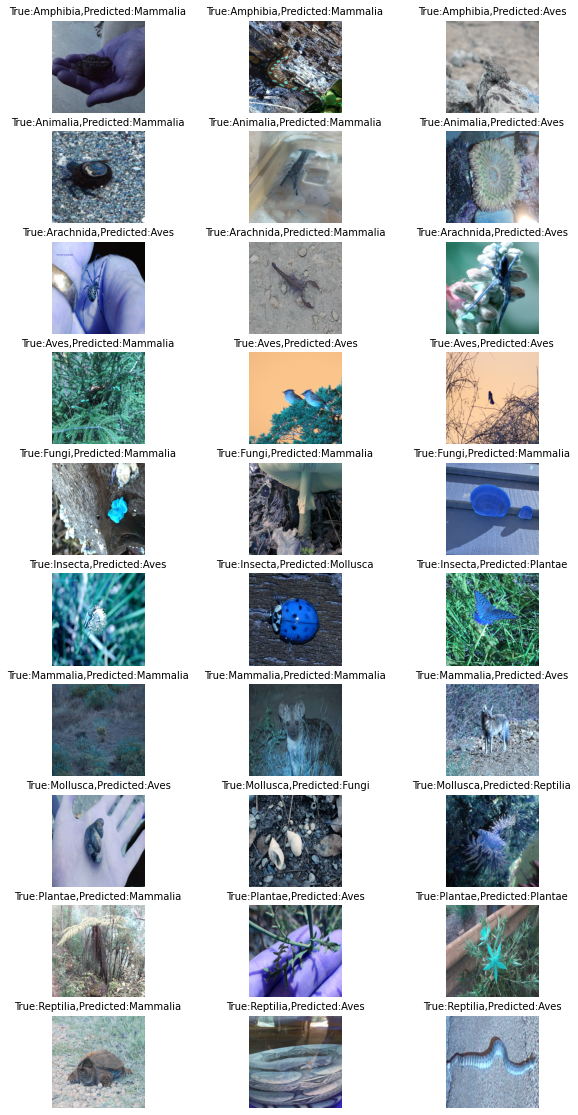

In [78]:
from IPython.core.display import JSON
#taking 30 sample images,3 from each class for visualizing

x,y,y_pred=[],[],[]
for clas in classes:
    count=0
    path=os.path.join(test_dir,clas)
    for img in os.listdir(path):
      if count==3: #only taking care of 3 images from each class
        break
      image = cv2.imread(os.path.join(path,img),cv2.IMREAD_COLOR)
      x.append(image)
      y.append(clas)
      pic = cv2.resize(image, (128,128)) / 255.0
      prediction = model.predict(pic.reshape(1,128, 128,3))
      c=prediction.argmax()
      y_pred.append(classes[c])
      count+=1
      
#plotting a 10x3 grid with predictions
fig = plt.figure(figsize=(10,20))
rows,columns=10,3
i=1
for k in range(30):

  img=cv2.resize(x[k],(512,512))
  fig.add_subplot(rows,columns,i)
  plt.imshow(img)
  plt.axis('off')
  plt.title('True:'+y[k]+',Predicted:'+y_pred[k],fontdict={'fontsize':10})
  i+=1 
wandb.init(entity='rashmi05pathak',project='assignment_2A')
wandb.log({'predicting on sample images':plt}) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


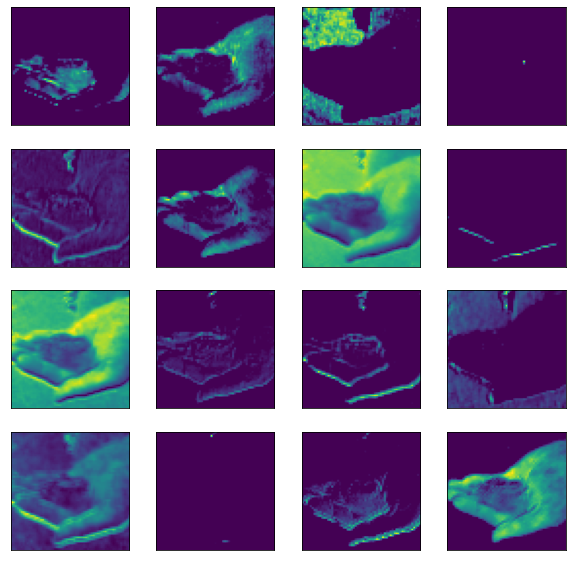

In [67]:
#visualizing filters

def fil_vis(lay='conv2d_1'):    #name of 1st conv layer
  fil_model = tf.keras.models.Model(inputs = [model.inputs], outputs = [model.get_layer(lay).output])
  clas = classes[0]
  dir=os.path.join(test_dir,clas)
  for img in os.listdir(dir):
    img_path=(os.path.join(dir,img))
    imgs=cv2.imread(img_path)
    imgs=mpimg.imread(img_path)
    new_img=cv2.resize(imgs,(128,128))
    x = np.expand_dims(new_img, axis=0) 
    inputs = tf.cast(x, tf.float32)
    out = fil_model(inputs)[0]

    # plot first few filters
    n_filters, ix = 16, 1
    plt.figure(figsize=(10,10))
    for i in range(n_filters):
      # get the filter
      f = out[:, :, i]
      # plot each channel separately
      for j in range(3):
        # specify subplot and turn of axis
        ax = plt.subplot(4, 4, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        plt.imshow(f)
      ix += 1
    # show the figure
    plt.show()
    break

fil_vis()